Esse notebook implementa o indice de ZCAS proposto no seguinte artigo:

https://link.springer.com/article/10.1007/s00382-018-4460-4

In [58]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install seaborn

In [3]:
#importar bibliotecas

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import sklearn.pipeline as skpl ##Convenient module for calculating PCs and using them in logistic regression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV



## 1) Importar Dados

como ainda nao tenho os dados, vou gerar dados similares e aleatorios.

In [96]:
#np.random.seed(1)
days = 5000
data = pd.DataFrame({"VAR1" : np.random.normal(0.0, 500.0, size=days),
                     "VAR2"  : np.random.normal(0.0, 10.0, size=days),
                     "VAR3" : np.random.normal(0.0, 50.0, size=days),
                     "VAR4"  : np.random.normal(0.0, 100.0, size=days),
                     "VAR5" : np.random.normal(0.0, 1000.0, size=days),
                     "VAR6"  : np.random.normal(0.0, 1.0, size=days),
                     "VAR7" : np.random.normal(0.0, 90.0, size=days),
                     "VAR8"  : np.random.normal(0.0, 100.0, size=days),
                     "VAR9" : np.random.normal(0.0, 30.0, size=days),
                     "VAR10_posit"  : np.random.normal(1000.0, 10.0, size=days),
                     "ZCAS" : np.where(np.random.normal(0.0, 1.0, size=days)<=0,0,1)})
print(data.head())
print(data.shape)

          VAR1       VAR2       VAR3        VAR4         VAR5      VAR6  \
0   542.320693  17.744287 -56.595055   68.846829   -64.381909 -1.605313   
1  -247.441560   9.908321 -63.066356 -126.947966  -525.136286 -1.907609   
2  -509.165552 -24.137628  29.184951   13.186146 -1182.952906  1.493037   
3  1322.007213  13.495170 -90.482716 -147.945292  -185.728763  0.234174   
4   325.772725 -15.370800 -61.125729  -41.272233   -95.998259 -1.313943   

         VAR7        VAR8       VAR9  VAR10_posit  ZCAS  
0  208.191574 -141.771079  77.715455  1002.264772     0  
1   13.191257  -17.034738 -20.804794   987.767467     0  
2   20.684192   10.140307 -34.952398  1017.982038     1  
3  -83.615825  -94.961640  -6.125837   988.413798     0  
4   50.344777  221.596556  -5.110803  1028.235033     1  
(5000, 11)


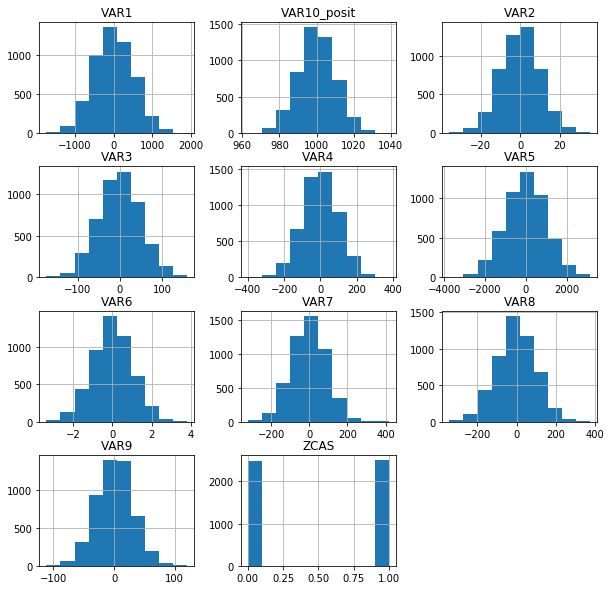

In [97]:
#plotando os dados so para verificar
data.hist(figsize=(10,10));

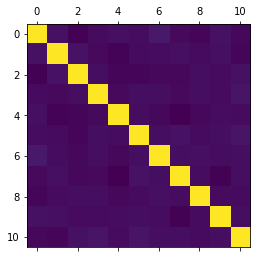

In [10]:
#correlation matrix
plt.matshow(data.corr())
plt.show()

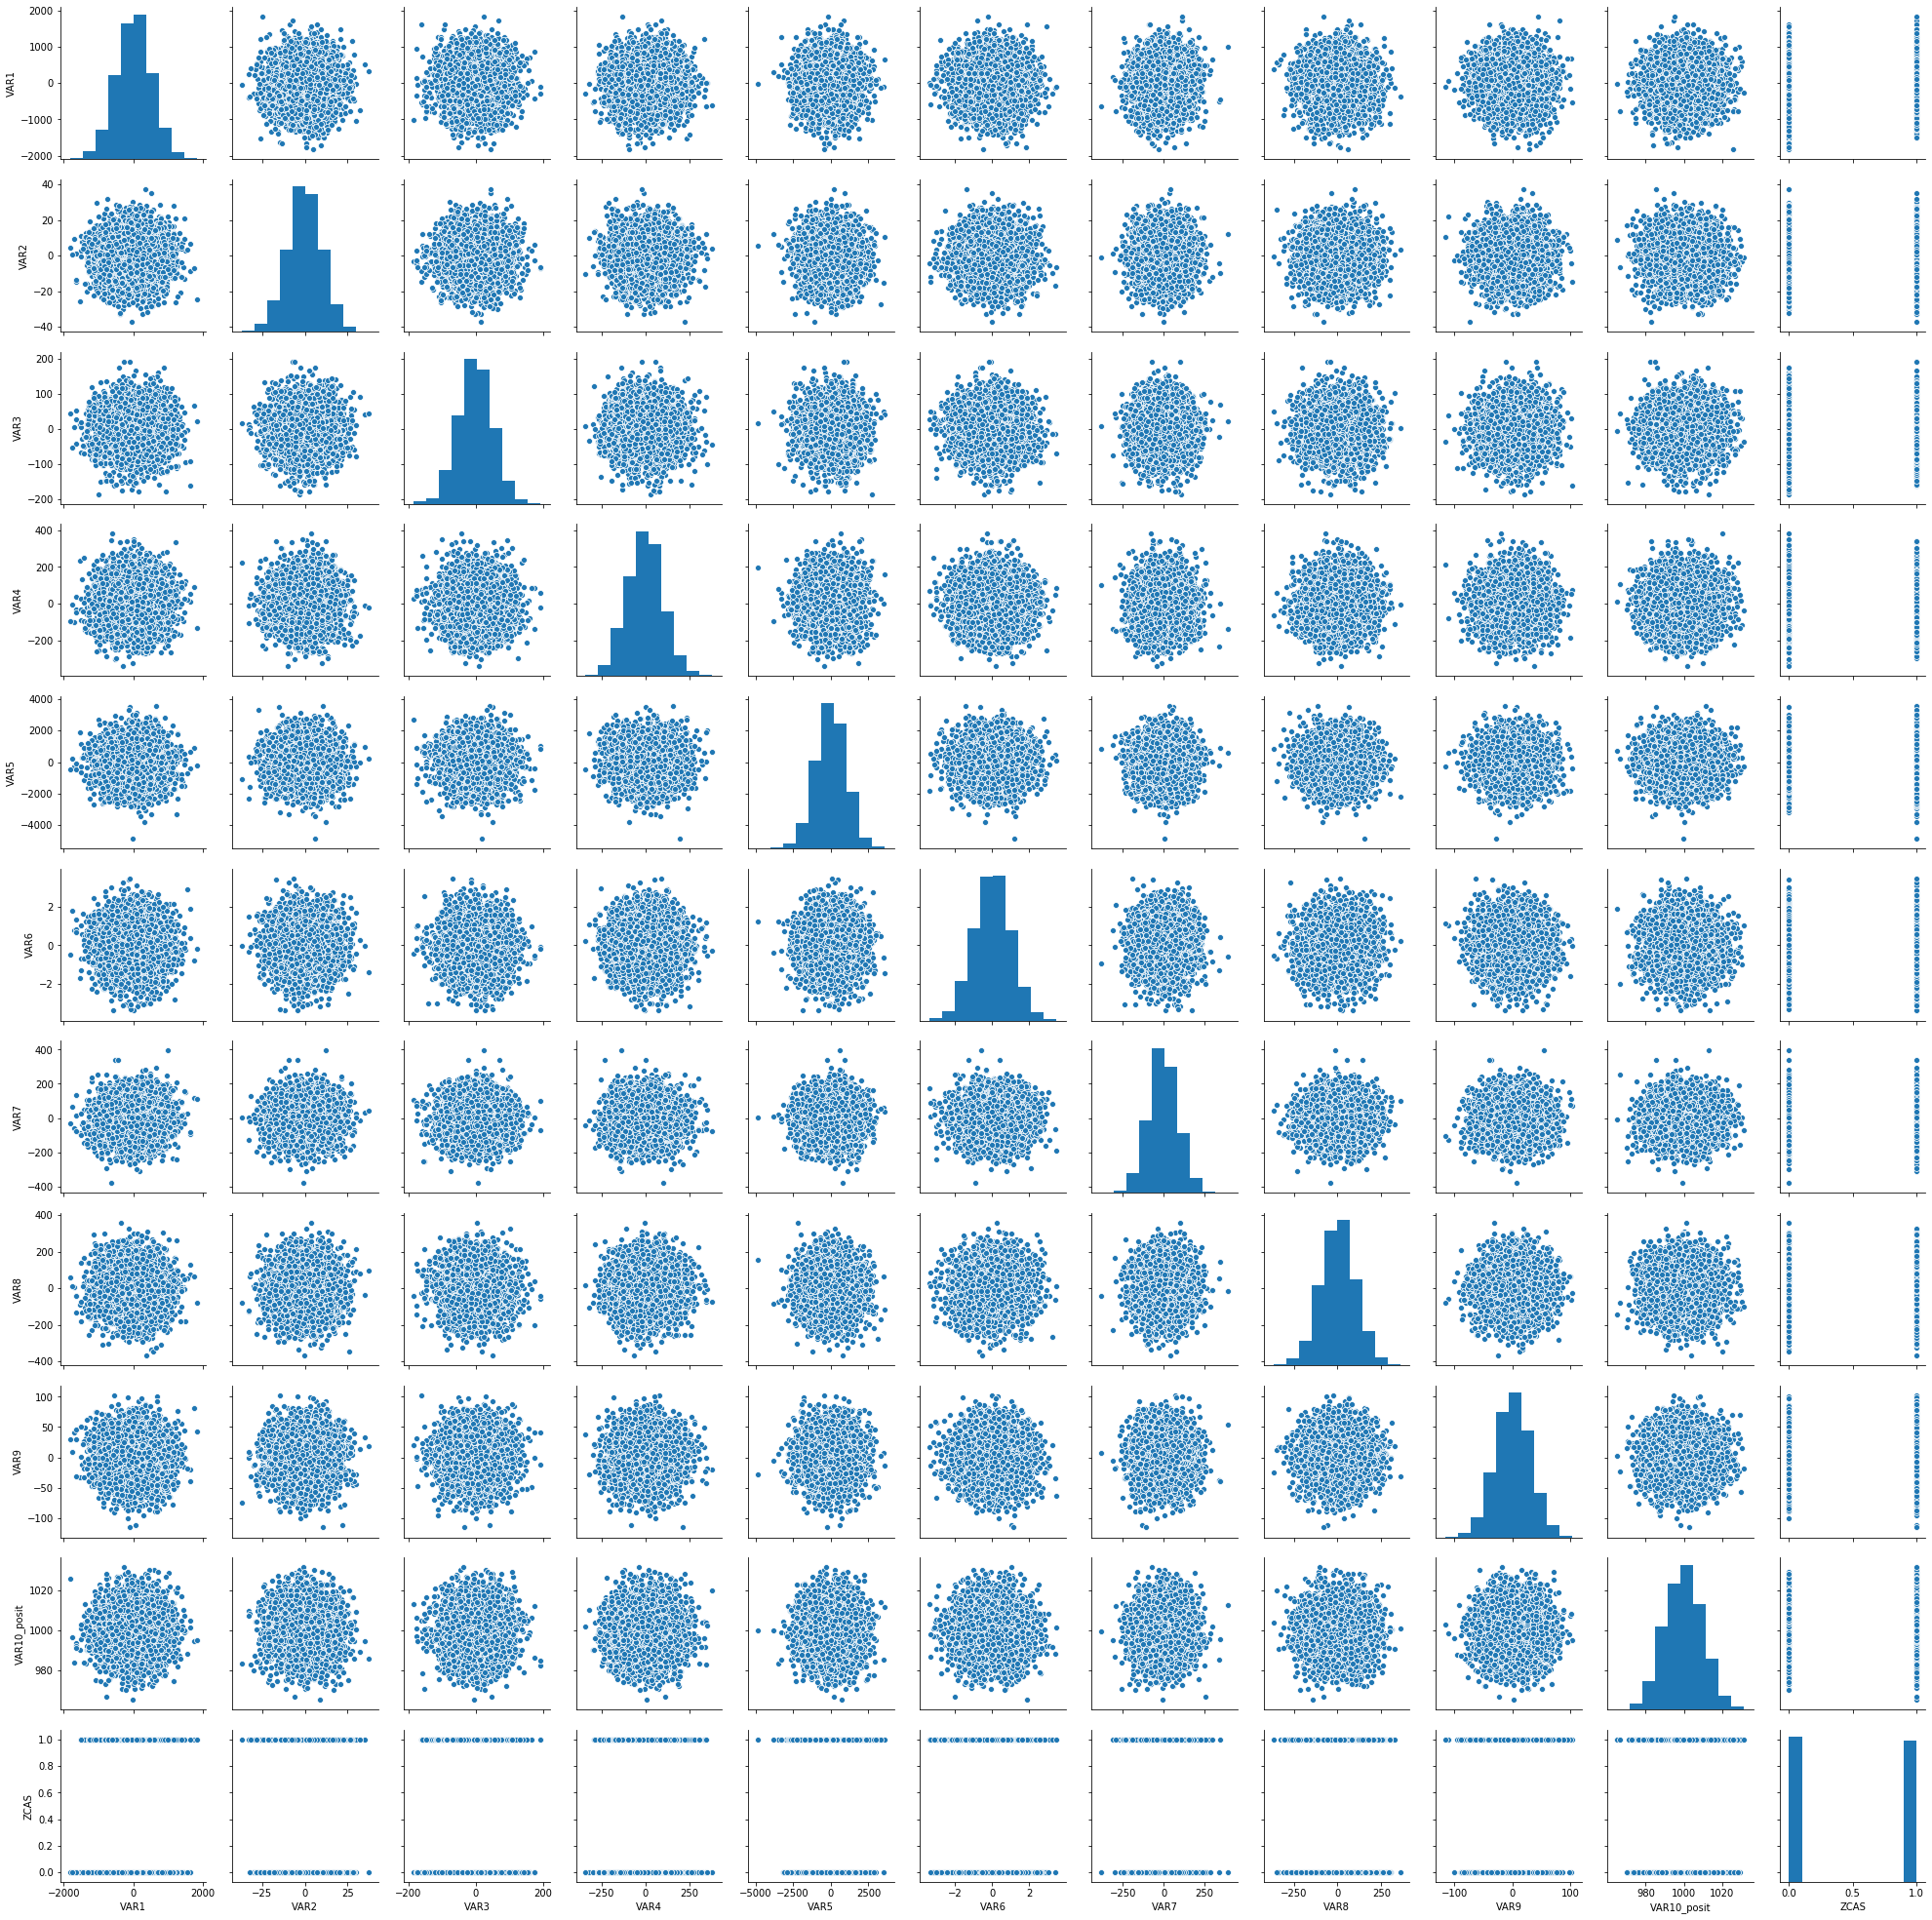

In [14]:
sns.pairplot(data)


In [98]:
#separar os previssores e a variavel-alvo
features = data.loc[:, data.columns != 'ZCAS']
target = data.loc[:, data.columns == 'ZCAS']

#outros exemplos de codigo
#x = df[df.columns[:5]]
#y = df.ZCAS

print("previssores")
print(features.head())
print(features.shape)
print("")
print("")
print("alvo")
print(target.head())
print(target.shape)

previssores
          VAR1       VAR2       VAR3        VAR4         VAR5      VAR6  \
0   542.320693  17.744287 -56.595055   68.846829   -64.381909 -1.605313   
1  -247.441560   9.908321 -63.066356 -126.947966  -525.136286 -1.907609   
2  -509.165552 -24.137628  29.184951   13.186146 -1182.952906  1.493037   
3  1322.007213  13.495170 -90.482716 -147.945292  -185.728763  0.234174   
4   325.772725 -15.370800 -61.125729  -41.272233   -95.998259 -1.313943   

         VAR7        VAR8       VAR9  VAR10_posit  
0  208.191574 -141.771079  77.715455  1002.264772  
1   13.191257  -17.034738 -20.804794   987.767467  
2   20.684192   10.140307 -34.952398  1017.982038  
3  -83.615825  -94.961640  -6.125837   988.413798  
4   50.344777  221.596556  -5.110803  1028.235033  
(5000, 10)


alvo
   ZCAS
0     0
1     0
2     1
3     0
4     1
(5000, 1)


## 2) Limpar dados

centralizar (mean = 0)

normalizar (-1 / +1)

       VAR1      VAR2      VAR3      VAR4      VAR5      VAR6      VAR7  \
0  1.072659  1.803555 -1.120643  0.688183 -0.053756 -1.576741  2.351849   
1 -0.484897  1.011750 -1.250153 -1.281890 -0.508882 -1.877359  0.177328   
2 -1.001065 -2.428509  0.596064  0.128130 -1.158663  1.504420  0.260884   
3  2.610344  1.374192 -1.798834 -1.493163 -0.173620  0.252542 -0.902204   
4  0.645587 -1.542643 -1.211315 -0.419827 -0.084986 -1.286987  0.591640   

       VAR8      VAR9  VAR10_posit  
0 -1.378397  2.565686     0.225367  
1 -0.130135 -0.707089    -1.223113  
2  0.141811 -1.177063     1.795738  
3 -0.909966 -0.219464    -1.158536  
4  2.257896 -0.185745     2.820153  


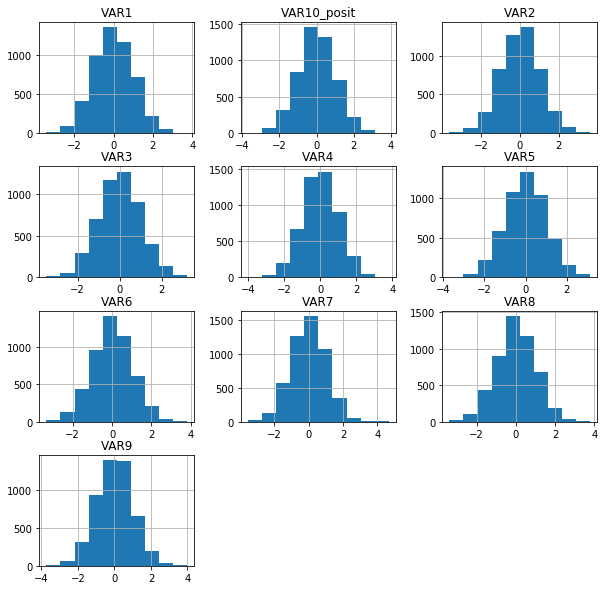

In [100]:
#normalizando os dados de treinamento

#computa os parametros para normalizacao
std_scale = preprocessing.StandardScaler().fit(features)

#normaliza os dados usando os parametros fitados
X_std = std_scale.transform(features)

#transforma de volta em dataframe
X_std = pd.DataFrame(X_std, index=features.index, columns=features.columns) 

#plota
print(X_std.head())
X_std.hist(figsize=(10,10));

## 3) Reducao de Dimensionalidade - PCA

In [101]:
#definir o numero de componentes: nesse caso, quero um numero que explique 95% da variancia
pca = PCA(.95)

#fit PCA on training set
principalComponents = pca.fit_transform(X_std)

#aplicar tanto para o conjunto de treinamento como de testo
X_std_pca = pca.transform(X_std)


In [102]:
var_explained = pca.explained_variance_ratio_ #computa o % de variacao explicado por cada PCA
print(pd.Series(var_explained))#printa 
print(sum(var_explained[0:10]))#printa a soma dos 10 primeiros PCAs

0    0.107589
1    0.104700
2    0.102407
3    0.101384
4    0.100249
5    0.100060
6    0.098668
7    0.096285
8    0.095313
9    0.093346
dtype: float64
0.9999999999999999


In [103]:
#Cria pandas dataframe com os PCAs
X_std_pca=pd.DataFrame(data=X_std_pca[0:,0:],
                    index=[i for i in range(X_std_pca.shape[0])],
                    columns=['PCA'+str(i) for i in range(X_std_pca.shape[1])])
X_std_pca.head()


,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9
0,-2.837517,-1.499796,-2.024909,1.510153,-0.089249,1.092094,0.518624,-2.118167,0.185637,-0.118922
1,0.686914,-0.111571,0.112342,0.815856,-1.022311,1.196203,0.065393,-1.421236,-2.117037,-0.384820
2,0.226997,0.894459,0.492860,-0.984166,-2.055357,-1.330648,-0.785245,2.165355,1.385526,0.540698
3,1.020741,-2.209672,-1.636967,-1.390413,0.716798,0.998014,-0.025326,-0.812403,-1.755824,-1.226000
4,-0.154943,0.943913,-1.619044,0.081911,-1.919815,-0.836900,2.755857,1.626188,-0.489690,1.063676


## 4) Implementar o Modelo

Binary logistic regression

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

Optimal number of features: 1
Selected features: ['PCA2']


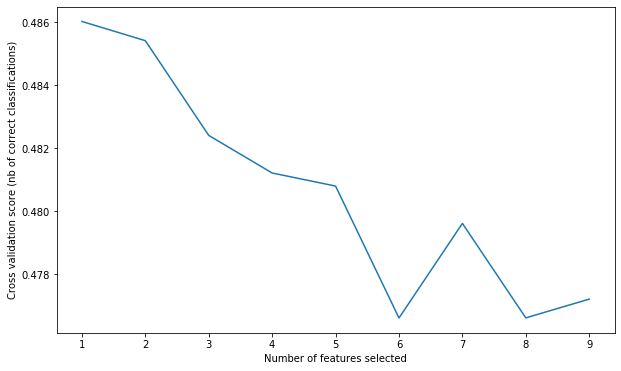

In [104]:
#Selecao de PCAs usando Recursive Feature Elimination with Cross Validation - RFECV

from sklearn.feature_selection import RFECV


cols = ["PCA0","PCA1","PCA2","PCA3","PCA4","PCA5","PCA6","PCA7","PCA9"] 
X = X_std_pca[cols]
y = target['ZCAS']

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(solver='lbfgs'), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

Selected_features = X.columns[rfecv.support_]

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.496
LogisticRegression log_loss is 0.693
LogisticRegression auc is 0.497


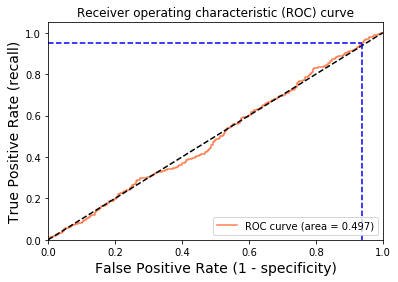

Using a threshold of 0.491 guarantees a sensitivity of 0.951 and a specificity of 0.063, i.e. a false positive rate of 93.71%.


In [106]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X = X_std_pca[Selected_features]
y = target['ZCAS']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

### cross validation

In [122]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


# create X (features) and y (response)
X = X_std_pca[Selected_features]
y = target['ZCAS']

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression(solver='lbfgs')

y_pred = cross_val_predict(modelCV, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(conf_mat)

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('')
print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

Confusion Matrix:
[[1060 1434]
 [1037 1469]]

K-fold cross-validation results:
LogisticRegression average accuracy: 0.506 (+/-0.023)
LogisticRegression average log_loss: 0.693 (+/-0.001)
LogisticRegression average auc: 0.505 (+/-0.024)


### GridSearchCV

## 5) Testar o modelo - GOF